In [3]:
cd /mnt/sda/otani/Experiments/moment_retrieval

/mnt/sda/otani/Experiments/moment_retrieval


In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from src.toolbox.eval import _tiou
from src.toolbox.data_converters import CharadesSTA2Instances
from src.toolbox.visualization import plot_performance_per_duration
import pickle as pkl
import json
import os
import random
from scipy.spatial.distance import pdist, squareform
pair_iou = lambda u, v: _tiou(u[None, :], v)

sns.set()
sns.set_style("white")

In [6]:
# load test set of Charade-STA
charade_groundtruth = CharadesSTA2Instances(pd.read_csv("data/processed/test.csv"))

In [7]:
# load re-annotated moments
data = []
for data_file in os.listdir("data/raw/AMT/charade-sta/"):
    if data_file.split(".")[-1] == 'csv':
        data.append(pd.read_csv(f"data/raw/AMT/charade-sta/{data_file}"))
data = pd.concat(data)

print(f"{len(data)} annotations, {len(data['HITId'].unique())} video-query pairs")

5000 annotations, 1000 video-query pairs


# Agreement between human annotators
Minimum IoU between re-annotated moments.

Text(0.5, 1.0, 'Median min IoU: 0.25')

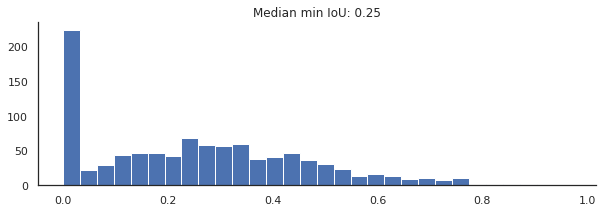

In [5]:
def compute_agreement(x):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    pred = np.vstack([st_perc, ed_perc]).T
    ious = squareform(pdist(pred, pair_iou))
    ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
    min_ious = ious.min()
    return min_ious

agreement = data.groupby("HITId").apply(compute_agreement).values
plt.figure(figsize=(10, 3))
plt.hist(agreement, bins=30)
sns.despine()
plt.title(f"Median min IoU: {np.median(agreement):.2f}")

# Human performance

## i. Randomly sample one annotator out of five

5 different annotators provided moment annotation for each sample.

To evaluate human performance, one annotator is randomly selected out of 5 for each sample.

In [6]:
def compute_iou_with_random_human(x):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    pred = np.vstack([st_perc, ed_perc]).T
    pred = random.choice(pred)
    
    video_id = x.iloc[0]["Input.video_url"][:-4]
    description = x.iloc[0]["Input.description"]
    for gt_instance in charade_groundtruth:
        if gt_instance[0] == (video_id, description):
            st_sec, ed_sec, length = gt_instance[1]
            break
            
    ious = _tiou(pred[None,:]*length/100, (st_sec, ed_sec))
    return ious

metrics = []
for _ in range(100):
    human_ious = data.groupby("HITId").apply(compute_iou_with_random_human).values
    r_at_1 = np.mean(np.hstack(human_ious) > .5)*100
    metrics.append(r_at_1)

print(f'[Random Human] R@1 (IoU>0.5): {np.mean(metrics):.1f} ({np.std(metrics):.2f})')

[Random Human] R@1 (IoU>0.5): 42.6 (1.07)


## ii. Select a representative annotator

We choose one representative annotator for each sample.

To obtain one representative annotator out of 5, we compute the pairwise IoUs among the moments from the 5 annotations (consequently, each annotator get 4 IoUs) and select one annotator as representative that have the largest average IoU. 

Representative annotators therefore are ones who are the most consistent with others.

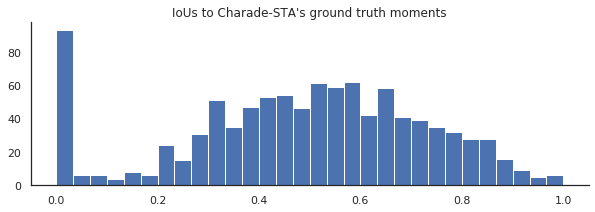

[Rep. Human] R@1 (IoU>0.5): 52.1


In [7]:
def eval_representative_human(x):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    pred = np.vstack([st_perc, ed_perc]).T
    ious = squareform(pdist(pred, pair_iou))
    ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
    index = np.argmax(np.mean(ious, axis=1))
    pred = pred[index]

    video_id = x.iloc[0]["Input.video_url"][:-4]
    description = x.iloc[0]["Input.description"]
    for gt_instance in charade_groundtruth:
        if gt_instance[0] == (video_id, description):
            st_sec, ed_sec, length = gt_instance[1]
            break
    pred = pred / 100 * length
    ious = _tiou(pred[None, :], (st_sec, ed_sec))
    return ious[0]
    
rep_human_ious = data.groupby("HITId").apply(eval_representative_human).values.ravel()
metric = np.mean(np.hstack(rep_human_ious) > .5)*100

plt.figure(figsize=(10, 3))
plt.hist(np.hstack(rep_human_ious), bins=30)
plt.title("IoUs to Charade-STA's ground truth moments")
sns.despine()
plt.show()

print(f"[Rep. Human] R@1 (IoU>0.5): {np.mean(metric):.1f}")

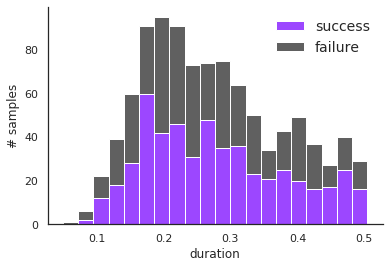

In [8]:
# output representative human response in the format for our toolbox

def convertAMTdata2result():
    
    for _, x in data.groupby("HITId"):
        st_perc = x["Answer.start"]
        ed_perc = x["Answer.end"]
        pred = np.vstack([st_perc, ed_perc]).T
        ious = squareform(pdist(pred, pair_iou))
        ious = ious[~np.eye(ious.shape[0],dtype=bool)].reshape(len(ious), -1)
        index = np.argmax(np.mean(ious, axis=1))
        pred = pred[index]

        video_id = x.iloc[0]["Input.video_url"][:-4]
        description = x.iloc[0]["Input.description"]
        for gt_instance in charade_groundtruth:
            if gt_instance[0] == (video_id, description):
                st_sec, ed_sec, length = gt_instance[1]
                break
        pred = pred / 100 * length
        iou_val = _tiou(pred[None, :], (st_sec, ed_sec))
        res = {'R@1 IoU>0.5': iou_val[0]>.5}
        yield (gt_instance[0], [pred.tolist()+[length]], [1], res)
        

def plot_per_duration():
    predictions = list(convertAMTdata2result())
    ground_truth = []
    for instance in predictions:
        for gt_instance in charade_groundtruth:
            if gt_instance[0] == instance[0]:
                ground_truth.append(gt_instance)
    plt.figure()
    plot_performance_per_duration(predictions, ground_truth, ax=plt.gca())
    plt.ylabel("# samples")
    plt.xlabel("duration")
    sns.despine()
    
plot_per_duration()

# Performance of k-th Best Human

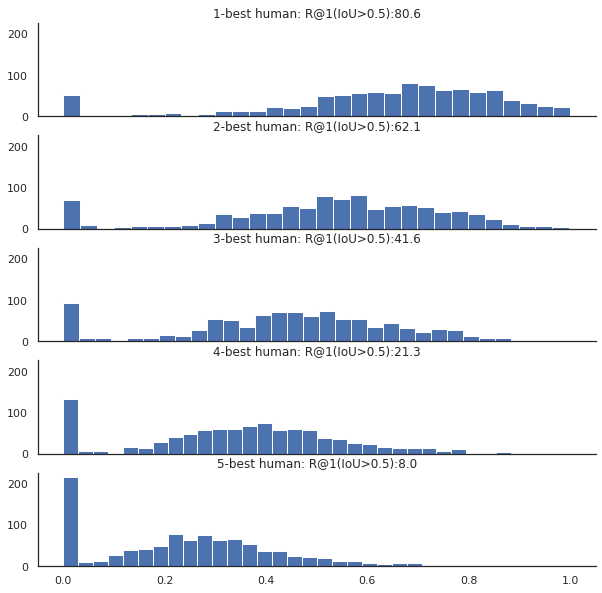

In [9]:
def compute_iou_at_k(x, k=[0, 1, 2, 3, 4]):
    st_perc = x["Answer.start"]
    ed_perc = x["Answer.end"]
    video_id = x.iloc[0]["Input.video_url"][:-4]
    description = x.iloc[0]["Input.description"]
    for gt_instance in charade_groundtruth:
        if gt_instance[0] == (video_id, description):
            st_sec, ed_sec, length = gt_instance[1]
            break
    pred = np.vstack([st_perc, ed_perc]).T / 100 * length
    ious = _tiou(pred, (st_sec, ed_sec))
    ious = ious[np.argsort(ious)[::-1][k]]
    return ious

human_ious = data.groupby("HITId").apply(lambda x: compute_iou_at_k(x))
human_ious = np.vstack(human_ious.values)
f, axes = plt.subplots(5, 1, figsize=(10, 10), sharex=True, sharey=True)
for ax, k in zip(axes, [0,1,2,3,4]):
    human_at_k = human_ious[:, k]
    ax.hist(human_at_k, bins=30)
    ax.set_title(f"{k+1}-best human: "+f"R@1(IoU>0.5):{np.mean(human_at_k > .5)*100:.1f}")
sns.despine()

In [10]:
# # save representative human response
# predictions = list(convertAMTdata2result())
# pkl.dump(predictions, open("reports/outputs/performance/charade-sta/representative_human.pkl", "wb"))

In [47]:
# Human annotation example

hitid = data["HITId"].sample().values[0]
sample_data = data[data["HITId"] == hitid][["Input.video_url","Answer.start", "Answer.end", "Input.description", "Input.start_sec", "Input.end_sec", "WorkerId"]]
video_id = sample_data["Input.video_url"].values[0]
description = sample_data["Input.description"].values[0]
pred_st = sample_data["Input.start_sec"].values[0]
pred_ed = sample_data["Input.end_sec"].values[0]
for gt_instance in charade_groundtruth:
    if gt_instance[0] == (video_id[:-4], description):
        st_sec, ed_sec, length = gt_instance[1]
print(sample_data[["Input.start_sec", "Input.end_sec"]].values[0])
print(st_sec, ed_sec)
sample_data[["Input.video_url", "Input.description", "Answer.start", "Answer.end"]].head()

[17.11249924 27.37999916]
11.7 19.8


,Input.video_url,Input.description,Answer.start,Answer.end
200,X07QW.mp4,next the person takes a blanket from a cabinet.,57,75
201,X07QW.mp4,next the person takes a blanket from a cabinet.,52,68
202,X07QW.mp4,next the person takes a blanket from a cabinet.,54,65
203,X07QW.mp4,next the person takes a blanket from a cabinet.,49,67
204,X07QW.mp4,next the person takes a blanket from a cabinet.,54,74


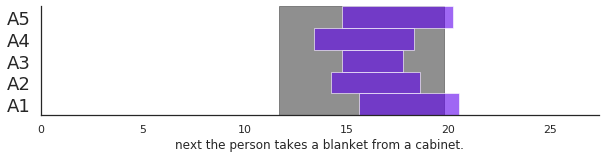

In [48]:
from IPython.display import Video
f = plt.figure(figsize=(10, 2))
plt.axvspan(st_sec, ed_sec, color="#606060", alpha=0.7)
plt.xlim([0, length])
plt.yticks([0.1, 0.3, 0.5, 0.7, 0.9], [f"A{i+1}" for i in range(5)], fontsize=18)

y = 0
for _, row in sample_data.iterrows():
    plt.axvspan(row["Answer.start"] * length/100,
                row["Answer.end"]*length/100,
                y, y+0.2,
                facecolor='#6002ee',
                alpha=0.6
                )
    y += 0.2
sns.despine()
plt.text(0.5*plt.gca().get_xlim()[1], -.3, description, horizontalalignment="center")

Video(f"http://localhost:8888/files/data/raw/video/{video_id}")

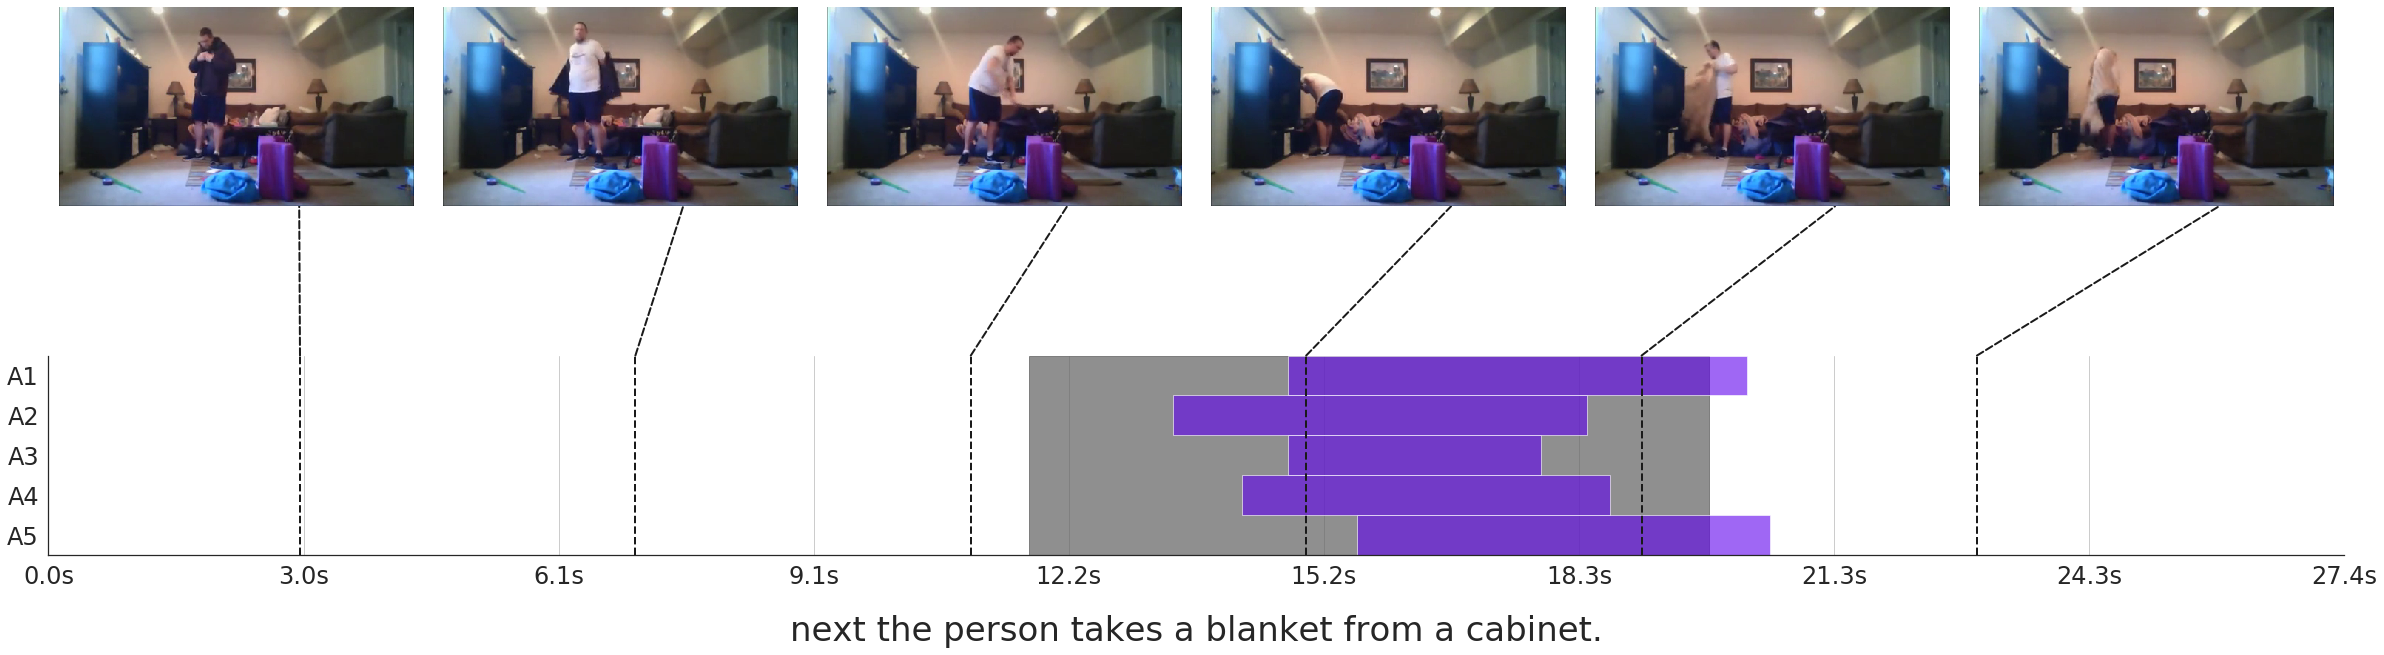

In [50]:
from matplotlib.patches import ConnectionPatch
from textwrap import wrap
from skvideo.io import vread

sns.set_style("white")
f = plt.figure(figsize=(11*3, 3*3), constrained_layout=True)

gs = f.add_gridspec(2, 6)

video_path = f"./data/raw/video/{video_id}"
video_arr = vread(video_path)

n_frame = len(video_arr)
sample_sec = np.linspace(0, int(length), 8).astype("i")
sample_sec = sample_sec[1:-1]
frames = [video_arr[int(n_frame / length * sec)] for sec in sample_sec]

ax_timeline= f.add_subplot(gs[1, :])

for i, frame in enumerate(frames):
    img_ax = f.add_subplot(gs[0, i])
    img_ax.imshow(frame)
    img_ax.axis("off")
    h, w, _ = frame.shape
    con = ConnectionPatch(xyA=[sample_sec[i], 1], xyB=[w*0.5, 0], coordsA="data", coordsB="axes points",
                      axesA=ax_timeline, axesB=img_ax, color='k', linestyle="--", linewidth=2)
    ax_timeline.add_artist(con)



ax_timeline.axvspan(st_sec, ed_sec, color="#606060", alpha=0.7)
ax_timeline.set_xlim([0, length])

y = 0
for _, row in sample_data.iterrows():
    ax_timeline.axvspan(row["Answer.start"] * length/100,
                row["Answer.end"]*length/100,
               y,y+0.2,
               facecolor='#6002ee',
                alpha=0.6
               )
    y += 0.2

for s in sample_sec:
    ax_timeline.axvline(s, linestyle="--", color="k", linewidth=2)
    
ax_timeline.set_xticks(np.linspace(0, length, 10))
ax_timeline.set_xticklabels([f'{s:.1f}s' for s in np.linspace(0, length, 10)], fontsize=24)
ax_timeline.set_yticks(np.linspace(0.1, 0.9, 5))
ax_timeline.set_yticklabels([f'A{a_id}' for a_id in [5,4,3,2,1]], fontsize=24)
ax_timeline.xaxis.grid()
sns.despine()
plt.sca(ax_timeline)

description = "\n".join(wrap(description))
plt.text(0.5*length,-0.3, description, fontsize=34, ha="center", va="top", wrap=True)

# plt.savefig(f'reports/figures/human_annotation/{hitid}.pdf',
#            bbox_inches='tight')